In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from PIL import Image
from torchinfo import summary
from tqdm.auto import tqdm

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

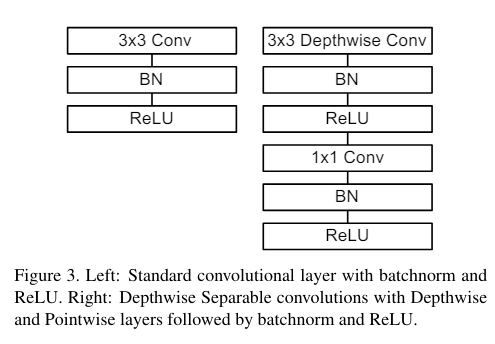

In [23]:
class MobileBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride) -> None:
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1, stride=stride, bias=None)
        self.bn1 = nn.BatchNorm2d(1)
        self.relu1 = nn.ReLU(inplace=True)

        self.pointwise = nn.Conv2d(1, out_channels, kernel_size=1, bias=None)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self,x):
        x = self.depthwise(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.pointwise(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        return x

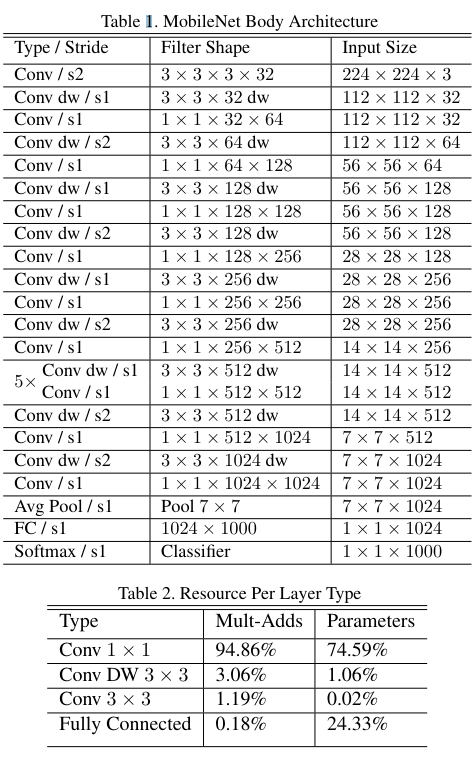

In [38]:
class MobileNet(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.features1 = nn.Sequential(
            ConvBlock(3, 32, 3, 2, padding=1),
            MobileBlock(32, 32, 1),
            ConvBlock(32, 64, 1, 1),
            MobileBlock(64, 64, 2),
            ConvBlock(64, 128, 1, 1),
            MobileBlock(128, 128, 1),
            ConvBlock(128, 128, 1, 1),
            MobileBlock(128, 128, 2),
            ConvBlock(128, 256, 1, 1),
            MobileBlock(256, 256, 1),
            ConvBlock(256, 256, 1, 1),
            MobileBlock(256, 256, 2),
            ConvBlock(256, 512, 1, 1)
        )

        block = nn.Sequential(
            MobileBlock(512, 512, 1),
            ConvBlock(512, 512, 1, 1)
        )

        self.features2 = nn.Sequential(
            *[block for _ in range(5)]
        )

        self.features3 = nn.Sequential(
            MobileBlock(512, 512, 2),
            ConvBlock(512, 1024, 1, 1),
            MobileBlock(1024, 1024, 1),
            ConvBlock(1024, 1024, 1, 1),    
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
model = MobileNet()

summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNet                                [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 14, 14]          --
│    └─ConvBlock: 2-1                    [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
│    └─MobileBlock: 2-2                  [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-4                  [1, 1, 112, 112]          288
│    │    └─BatchNorm2d: 3-5             [1, 1, 112, 112]          2
│    │    └─ReLU: 3-6                    [1, 1, 112, 112]          --
│    │    └─Conv2d: 3-7                  [1, 32, 112, 112]         32
│    │    └─BatchNorm2d: 3-8             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-9                    [1, 32, 112, 112]         --
│    └─ConvBlo

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import time
import copy

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# 데이터셋 및 데이터 로더 설정
train_dataset = ImageFolder(root='E:\\puzzle\\data\\ImageNet10\\train', transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_dataset = ImageFolder(root='E:\\puzzle\\data\\ImageNet10\\val', transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

model = MobileNet(num_classes=10).to(device)
loss_func = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001) #Rmsprop으로 진행할때 너무 학습이 들쭉날쭉함.

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metric_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, outputs, target, opt=None):
    if isinstance(outputs, tuple):
        output, aux1, aux2 = outputs

        output_loss = loss_func(output, target)
        aux1_loss = loss_func(aux1, target)
        aux2_loss = loss_func(aux2, target)

        loss = output_loss + 0.3*(aux1_loss + aux2_loss)
        metric_b = metric_batch(output, target)
    else:
        loss = loss_func(outputs, target)
        metric_b = metric_batch(outputs, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b

def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in tqdm(dataset_dl, leave=False):
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

def train_val(model, params):
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    path2weights = params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    start_time = time.time()
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)


        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' % (train_loss, val_loss, 100 * val_metric, (time.time() - start_time) / 60))
        print('-' * 10)

    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

params_train = {
    "num_epochs": 70,
    "loss_func": loss_func,
    "optimizer": optimizer,
    "train_dl": train_loader,
    "val_dl": val_loader,
    "sanity_check": False,
    "path2weights": "best_weights.pt",
}

# 학습 및 유효성 검사 수행
model, loss_history, metric_history = train_val(model, params_train)

Epoch 0/69, current lr=0.001


  0%|          | 0/325 [00:09<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

Copied best model weights!
train loss: 2.250989, val loss: 2.200402, accuracy: 18.35, time: 1.1933 min
----------
Epoch 1/69, current lr=0.001


  0%|          | 0/325 [00:08<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

Copied best model weights!
train loss: 2.171134, val loss: 2.148560, accuracy: 19.54, time: 3.6975 min
----------
Epoch 2/69, current lr=0.001


  0%|          | 0/325 [00:09<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

Copied best model weights!
train loss: 2.130960, val loss: 2.083468, accuracy: 23.08, time: 4.8546 min
----------
Epoch 3/69, current lr=0.001


  0%|          | 0/325 [00:09<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

train loss: 2.131331, val loss: 2.214122, accuracy: 16.62, time: 6.0425 min
----------
Epoch 4/69, current lr=0.001


  0%|          | 0/325 [00:09<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

Copied best model weights!
train loss: 2.099480, val loss: 2.052742, accuracy: 22.65, time: 8.9440 min
----------
Epoch 5/69, current lr=0.001


  0%|          | 0/325 [00:09<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

train loss: 2.131869, val loss: 2.188603, accuracy: 15.73, time: 10.1384 min
----------
Epoch 6/69, current lr=0.001


  0%|          | 0/325 [00:09<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

train loss: 2.091645, val loss: 2.351697, accuracy: 21.46, time: 11.3288 min
----------
Epoch 7/69, current lr=0.001


  0%|          | 0/325 [00:09<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

train loss: 2.175370, val loss: 2.091108, accuracy: 18.81, time: 12.6001 min
----------
Epoch 8/69, current lr=0.001


  0%|          | 0/325 [00:09<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

train loss: 2.131033, val loss: 2.060023, accuracy: 22.81, time: 16.3163 min
----------
Epoch 9/69, current lr=0.001


  0%|          | 0/325 [00:09<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

train loss: 2.109167, val loss: 2.232032, accuracy: 17.27, time: 17.4710 min
----------
Epoch 10/69, current lr=0.001


  0%|          | 0/325 [00:08<?, ?it/s]

  0%|          | 0/82 [00:08<?, ?it/s]

train loss: 2.106799, val loss: 2.203684, accuracy: 18.35, time: 18.6279 min
----------
Epoch 11/69, current lr=0.001


  0%|          | 0/325 [00:09<?, ?it/s]

  0%|          | 0/82 [00:08<?, ?it/s]

train loss: 2.101032, val loss: 2.416636, accuracy: 15.81, time: 19.7842 min
----------
Epoch 12/69, current lr=0.001


  0%|          | 0/325 [00:09<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

train loss: 2.126191, val loss: 3.221260, accuracy: 10.00, time: 21.0267 min
----------
Epoch 13/69, current lr=0.001


  0%|          | 0/325 [00:09<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

train loss: 2.106439, val loss: 2.145928, accuracy: 16.58, time: 22.2700 min
----------
Epoch 14/69, current lr=0.001


  0%|          | 0/325 [00:08<?, ?it/s]

  0%|          | 0/82 [00:09<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001CA37156C20>
Traceback (most recent call last):
  File "c:\Users\urise\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\urise\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\urise\AppData\Local\Programs\Python\Python310\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "c:\Users\urise\AppData\Local\Programs\Python\Python310\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 
